## Carregamento e Limpeza dos Dados

Antes de qualquer análise, precisamos garantir que os dados estejam legíveis e padronizados.

Na tabela original, existiam muitas colunas desnecessárias para análise e dados que comprometem a LGPD. Assim, tomei liberdade de, em uma cópia da planilha original, apagar colunas desnecessárias. 

Após selecionar as colunas mais importantes e que possuiam maior valor, surgiram estes problemas:

- **CNAE** preenchido em formatos variados (com pontos, traços, misturados)
- **Faturamento** como texto com "R$", além de valores zero que podem indicar dado não informado
- **Estado** com nomes por extenso, siglas e até países estrangeiros
- **Ano de fundação** com mistura de tipos — algumas células foram interpretadas pelo Excel como data em vez de número inteiro

Cada um desses problemas é tratado abaixo antes de iniciar a análise.

In [22]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import seaborn as sns
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
import unicodedata
import numpy as np
from wordcloud import WordCloud, STOPWORDS

## Limpeza: CNAE

In [23]:
df = pd.read_excel('empresas_dna.xlsx')

# Renomeando as colunas para nomes mais práticos
df.columns = ['nome', 'ano_fundacao', 'cnae', 'cidade', 'estado', 'descricao', 'faturamento']

# Remove tudo o que não for dígito 
df['cnae_limpo'] = df['cnae'].astype(str).apply(lambda x: re.sub(r'\D', '', x))

# Extrai os 2 primeiros dígitos (divisão do CNAE) para melhor classificação
df['cnae_divisao'] = df['cnae_limpo'].str[:2]

## Limpeza: Faturamento

In [24]:
def limpar_faturamento(valor):
    if pd.isna(valor):
        return None
    texto = str(valor)
    texto = texto.replace('R$', '').replace('', '')
    texto = texto.replace('.', '').replace(',', '.')
    try:
        numero = float(texto)
        return numero if numero > 0 else None 
    except:
        return None

df['faturamento_num'] = df['faturamento'].apply(limpar_faturamento)


## Limpeza: Estado

In [25]:
SIGLAS_BR = {
    'AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS',
    'MG','PA','PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC',
    'SP','SE','TO'
}

NOMES_PARA_SIGLA = {
    'SAO PAULO': 'SP', 'SÃO PAULO': 'SP', 'MINAS GERAIS': 'MG',
    'RIO DE JANEIRO': 'RJ', 'PARANA': 'PR', 'PARANÁ': 'PR',
    'SANTA CATARINA': 'SC', 'RIO GRANDE DO SUL': 'RS',
    'BAHIA': 'BA', 'GOIAS': 'GO', 'GOIÁS': 'GO',
    'MATO GROSSO': 'MT', 'MATO GROSSO DO SUL': 'MS',
    'PERNAMBUCO': 'PE', 'CEARA': 'CE', 'CEARÁ': 'CE',
}

In [26]:
def padronizar_estado(valor):
    if pd.isna(valor):
        return 'Não informado'
    
    texto = str(valor).strip().upper()
    
    # Tenta extrair sigla entre parênteses: "São Paulo (SP)" → "SP"
    match = re.search(r'\(([A-Z]{2})\)', texto)
    if match:
        sigla = match.group(1)
        return sigla if sigla in SIGLAS_BR else 'Exterior'
    
    # Verifica se já é uma sigla válida
    if texto in SIGLAS_BR:
        return texto
    
    # Tenta mapear nome por extenso
    if texto in NOMES_PARA_SIGLA:
        return NOMES_PARA_SIGLA[texto]
    
    # Se não reconheceu, marca como Exterior
    return 'Exterior'

df['estado_limpo'] = df['estado'].apply(padronizar_estado)

## Limpeza: Ano de Fundação

In [27]:
# Extrai só o ano, independente de ser número, texto ou data
def limpar_ano(valor):
    if pd.isna(valor):
        return None
    if isinstance(valor, (int, float)):
        return int(valor)
    if hasattr(valor, 'year'):       # é um datetime
        return valor.year
    try:
        return int(str(valor)[:4])   # tenta pegar os 4 primeiros caracteres
    except:
        return None

df['ano_fundacao'] = df['ano_fundacao'].apply(limpar_ano)

## Resultado e Diagnóstico da base

In [28]:
print(f"Total de empresas: {len(df)}")
print(f"Faturamento não informado ou zero: {df['faturamento_num'].isna().sum()}")
print(f"\nDistribuição por tipo de estado:")
print(df['estado_limpo'].value_counts().head(10))

Total de empresas: 3211
Faturamento não informado ou zero: 951

Distribuição por tipo de estado:
estado_limpo
SP          2815
MG            62
PR            47
SC            28
BA            25
RJ            24
GO            23
Exterior      23
RS            22
DF            22
Name: count, dtype: int64


In [29]:
print("=== VALORES AUSENTES POR COLUNA ===")
print(df.isna().sum())

print("\n=== ANO DE FUNDAÇÃO ===")
print(f"Mínimo: {df['ano_fundacao'].min()}")
print(f"Máximo: {df['ano_fundacao'].max()}")
print(f"Nulos:  {df['ano_fundacao'].isna().sum()}")

print("\n=== CNAE (primeiros dígitos mais frequentes) ===")
print(df['cnae_divisao'].value_counts().head(10))

print("\n=== FATURAMENTO (empresas com dado válido) ===")
print(df['faturamento_num'].describe().apply(lambda x: f'R$ {x:,.2f}'))

=== VALORES AUSENTES POR COLUNA ===
nome                 0
ano_fundacao         0
cnae                 0
cidade               0
estado               0
descricao            0
faturamento        494
cnae_limpo           0
cnae_divisao         0
faturamento_num    951
estado_limpo         0
dtype: int64

=== ANO DE FUNDAÇÃO ===
Mínimo: 1905
Máximo: 1062021
Nulos:  0

=== CNAE (primeiros dígitos mais frequentes) ===
cnae_divisao
85    480
86    437
62    323
71    237
74    166
72    157
47    145
82    130
70    109
63    104
Name: count, dtype: int64

=== FATURAMENTO (empresas com dado válido) ===
count             R$ 2,260.00
mean         R$ 17,906,345.03
std         R$ 331,219,922.64
min                  R$ 12.00
25%              R$ 60,000.00
50%              R$ 62,417.50
75%             R$ 360,000.00
max      R$ 11,300,000,000.00
Name: faturamento_num, dtype: str


### Última limpeza, considerando o que foi mostrado no diagnóstico

In [30]:
df['ano_fundacao'] = df['ano_fundacao'].where(
    df['ano_fundacao'].between(1900, 2025), other=None
)

# Mantemos a Telar na base mas sinalizamos para contexto nos gráficos
df['faturamento_outlier'] = df['faturamento_num'] > 1_000_000_000  # acima de 1 bilhão

In [31]:
print("=== BASE APÓS LIMPEZA ===")
print(f"Total de empresas:                {len(df)}")
print(f"Anos inválidos corrigidos:         {df['ano_fundacao'].isna().sum()}")
print(f"Sem faturamento informado:         {df['faturamento_num'].isna().sum()}")
print(f"Empresas do exterior:              {(df['estado_limpo'] == 'Exterior').sum()}")
print(f"Outliers de faturamento (>1bi):    {df['faturamento_outlier'].sum()}")
print(f"\nBase pronta para análise!")

=== BASE APÓS LIMPEZA ===
Total de empresas:                3211
Anos inválidos corrigidos:         3
Sem faturamento informado:         951
Empresas do exterior:              23
Outliers de faturamento (>1bi):    7

Base pronta para análise!


# Gráficos

### Boxplot de faturamentos

Um boxplot resume a distribuição de valores em cinco medidas: mínimo, máximo, mediana 
e os quartis Q1 (25%) e Q3 (75%). Pontos fora dos "bigodes" são outliers — valores 
muito acima ou abaixo do esperado.

O gráfico é apresentado em dois painéis: com e sem o top 5% dos valores, para revelar 
tanto os extremos quanto a distribuição da maioria das empresas.

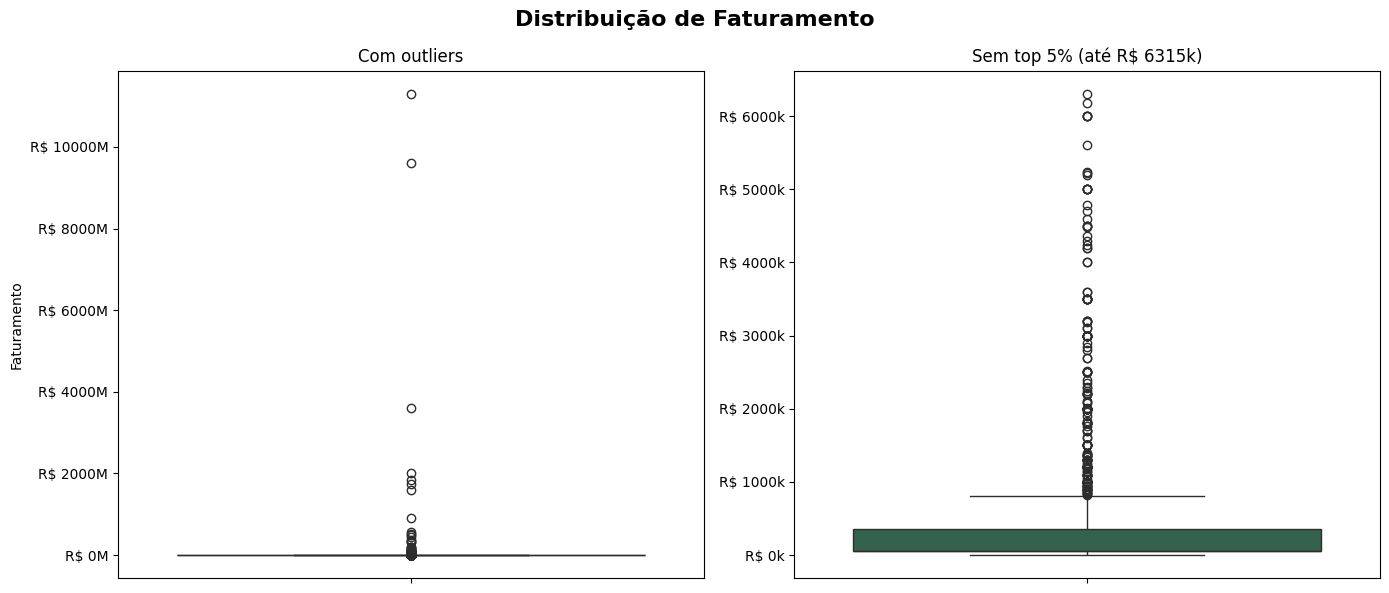

In [32]:
df_fat = df.dropna(subset=['faturamento_num']).copy()
p95    = df_fat['faturamento_num'].quantile(0.95)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribuição de Faturamento', fontsize=16, fontweight='bold')

# 1° Painel: todos os valores da planilha 
sns.boxplot(y=df_fat['faturamento_num'], ax=axes[0], color='#2d6a4f')
axes[0].set_title('Com outliers')
axes[0].set_ylabel('Faturamento')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x/1e6:.0f}M'))

# Painel 2: sem top 5%
sns.boxplot(y=df_fat[df_fat['faturamento_num'] <= p95]['faturamento_num'],
            ax=axes[1], color='#2d6a4f')
axes[1].set_title(f'Sem top 5% (até R$ {p95/1e3:.0f}k)')
axes[1].set_ylabel('')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x/1e3:.0f}k'))

plt.tight_layout()
plt.show()

In [33]:
outliers = (df_fat[df_fat['faturamento_num'] > p95]
            [['nome', 'cidade', 'estado_limpo', 'faturamento_num']]
            .sort_values('faturamento_num', ascending=False)
            .assign(faturamento=lambda x: x['faturamento_num']
                    .apply(lambda v: f'R$ {v:,.0f}'.replace(',', '.')))
            .drop(columns='faturamento_num'))

print(f"Empresas acima do percentil 95 (R$ {p95/1e3:.0f}k): {len(outliers)}")
print(outliers.to_string(index=False))

Empresas acima do percentil 95 (R$ 6315k): 113
                                                     nome                cidade estado_limpo       faturamento
                                         Telar Engenharia             São Paulo           SP R$ 11.300.000.000
                          Cosan S.A. Indústria e Comércio             São Paulo           SP  R$ 9.606.000.000
                           Ventura Veterinária & Pet shop             São Paulo           SP  R$ 3.600.000.000
                                          MM Optics Ltda.            São Carlos           SP  R$ 2.000.000.000
                                                  Duratex             São Paulo           SP  R$ 1.851.820.000
                                                    TOTVS             São Paulo           SP  R$ 1.733.189.000
                            AvilaVet - Plano de saude Pet                 Ibaté           SP  R$ 1.600.000.000
                                      Nordic Water Brasil        

### Gráfico de colunas com data de criação das empresas

O gráfico apresenta a evolução histórica de abertura de empresas na base, a partir de 1963.
A linha laranja representa a média móvel de 3 anos, que suaviza variações pontuais e 
evidencia a tendência de crescimento de longo prazo. O crescimento acelerado a partir 
dos anos 2000 reflete o amadurecimento do ecossistema empreendedor brasileiro.

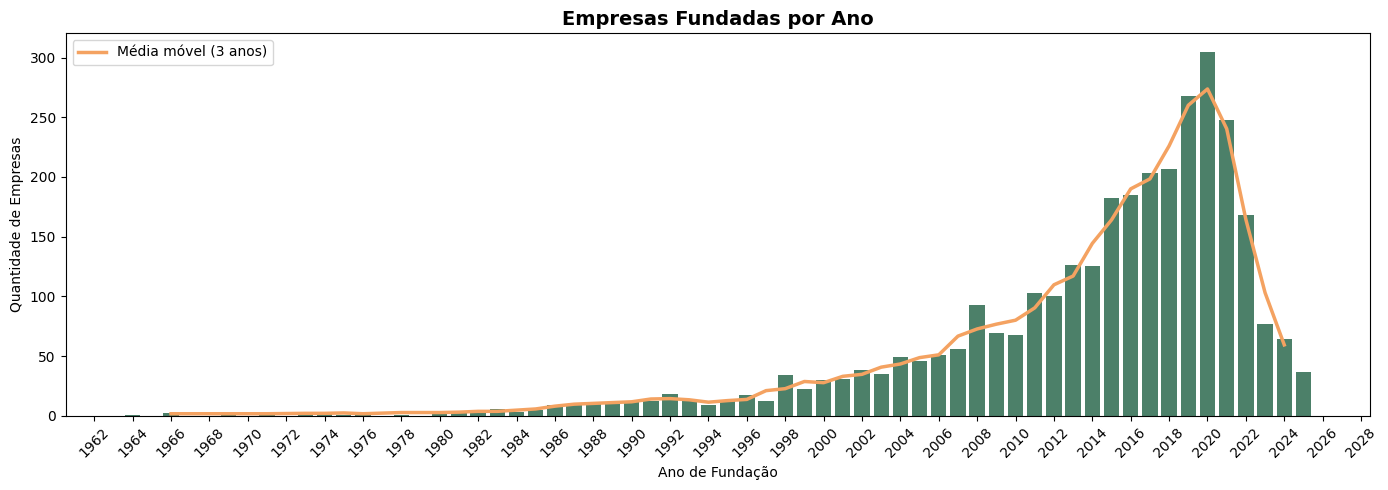

In [34]:
df_ano = (df[df['ano_fundacao'] >= 1963]
            .dropna(subset=['ano_fundacao'])
            .groupby('ano_fundacao')
            .size()
            .reset_index(name='quantidade'))

fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(df_ano['ano_fundacao'], df_ano['quantidade'],
       color='#2d6a4f', alpha=0.85, width=0.8)

# Linha de tendência suavizada
df_ano['media_movel'] = df_ano['quantidade'].rolling(window=3, center=True).mean()
ax.plot(df_ano['ano_fundacao'], df_ano['media_movel'],
        color='#f4a261', linewidth=2.5, label='Média móvel (3 anos)')

ax.set_title('Empresas Fundadas por Ano', fontsize=14, fontweight='bold')
ax.set_xlabel('Ano de Fundação')
ax.set_ylabel('Quantidade de Empresas')
ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Heatmap de empresas por estado/pais

In [35]:
brasil = gpd.read_file(
    'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
)

# Padroniza a coluna de sigla para fazer o merge
brasil['sigla'] = brasil['sigla'].str.upper()

# ── Merge com os dados de quantidade por estado ─────────────────────────────
df_estado = (df.groupby('estado_limpo')
               .size()
               .reset_index(name='quantidade'))

mapa = brasil.merge(df_estado, left_on='sigla', right_on='estado_limpo', how='left')
mapa['quantidade'] = mapa['quantidade'].fillna(0)

O mapa apresenta a concentração de empresas por estado brasileiro, utilizando uma 
**escala de cores logarítmica**. Essa escolha metodológica é necessária pois São Paulo 
concentra 87% da base (2.815 empresas), o que tornaria os demais estados invisíveis 
em uma escala linear convencional.

Com a escala logarítmica, diferenças entre estados menores ficam visíveis, 
permitindo comparar a distribuição regional sem perder a informação de que SP domina a base.
Estados sem nenhuma empresa cadastrada aparecem em cinza claro.

In [36]:
# ── Carrega shapefile dos municípios de SP ───────────────────────────────────
sp_mapa = gpd.read_file(
    'https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-35-mun.json'
)
sp_mapa['name'] = sp_mapa['name'].str.upper().str.strip()

# ── Cria df_sp e df_sp_cidade ────────────────────────────────────────────────
df_sp = df[(df['estado_limpo'] == 'SP') & df['faturamento_num'].notna()].copy()

def normalizar_cidade(nome):
    if pd.isna(nome):
        return None
    nome = str(nome).replace('\xa0', ' ').strip().replace('-SP', '').strip().replace('´', "'")
    correcoes = {
        'SAO PAULO':             'SÃO PAULO',
        'SAO CARLOS':            'SÃO CARLOS',
        'EMBU DAS ARTES':        'EMBU',
        "SANTA BARBARA D'OESTE": "SANTA BÁRBARA D'OESTE",
        'SANTO AMARO':           'SÃO PAULO',
    }
    return correcoes.get(nome, nome)

df_sp['cidade'] = df_sp['cidade'].apply(normalizar_cidade)
df_sp = df_sp[df_sp['cidade'] != 'N/D']

df_sp_cidade = (df_sp.groupby('cidade')['faturamento_num']
                     .agg(media='mean', count='count')
                     .reset_index())

print(f"✅ sp_mapa: {len(sp_mapa)} municípios")
print(f"✅ df_sp_cidade: {len(df_sp_cidade)} cidades")

✅ sp_mapa: 645 municípios
✅ df_sp_cidade: 152 cidades


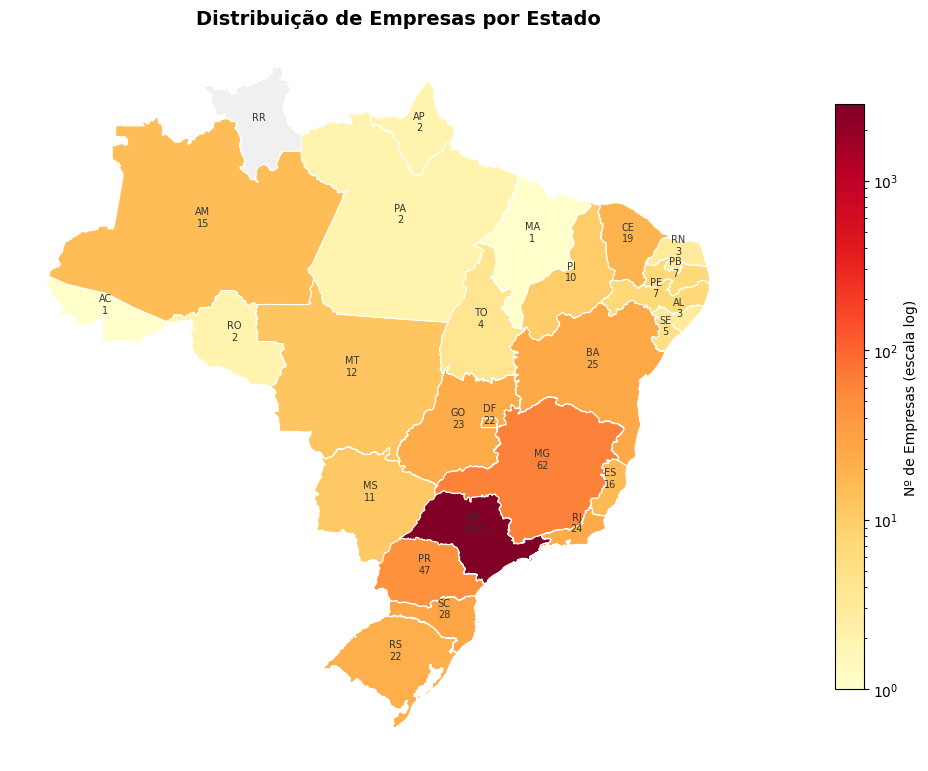

In [37]:
fig, ax = plt.subplots(figsize=(10, 12))

norm = LogNorm(vmin=1, vmax=mapa['quantidade'].max())

mapa[mapa['quantidade'] > 0].plot(
    column='quantidade', cmap='YlOrRd', linewidth=0.8,
    edgecolor='white', legend=False, norm=norm, ax=ax
)
# Estados sem empresas em cinza claro
mapa[mapa['quantidade'] == 0].plot(
    color='#f0f0f0', edgecolor='white', linewidth=0.8, ax=ax
)

# Colorbar manual
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, label='Nº de Empresas (escala log)')

# Siglas + quantidade
for _, row in mapa.iterrows():
    centroid = row.geometry.centroid
    qtd = int(row['quantidade'])
    label = f"{row['sigla']}\n{qtd}" if qtd > 0 else row['sigla']
    ax.annotate(label, xy=(centroid.x, centroid.y),
                ha='center', fontsize=7, color='#333333')

ax.set_title('Distribuição de Empresas por Estado', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### Correções dos nomes do municipios do estado de SP

In [38]:
sp_mapa = gpd.read_file(
    'https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-35-mun.json'
)

In [39]:
sp_mapa['name'] = sp_mapa['name'].str.upper().str.strip()

mapa_sp = sp_mapa.merge(df_sp_cidade, left_on='name', right_on='cidade', how='left')
mapa_sp['media'] = mapa_sp['media'].fillna(0)
mapa_sp['count'] = mapa_sp['count'].fillna(0).astype(int)
mapa_sp['media_fmt'] = mapa_sp['media'].apply(lambda x: f'R$ {x:,.0f}'.replace(',', '.') if x > 0 else 'Sem dados')

In [40]:
correcoes = {
    'SAO PAULO':                'SÃO PAULO',
    'SAO CARLOS':               'SÃO CARLOS',
    'EMBU DAS ARTES':           'EMBU',
    "SANTA BARBARA D'OESTE":    "SANTA BÁRBARA D'OESTE",
    'SANTO AMARO':              'SÃO PAULO',
}

def normalizar_cidade(nome):
    if pd.isna(nome):
        return None
    nome = str(nome)
    nome = nome.replace('\xa0', ' ').strip()
    nome = nome.replace('-SP', '').strip()
    nome = nome.replace('´', "'")
    return correcoes.get(nome, nome)

df_sp['cidade'] = df_sp['cidade'].apply(normalizar_cidade)
df_sp = df_sp[df_sp['cidade'] != 'N/D']

df_sp_cidade = (df_sp.groupby('cidade')['faturamento_num']
                     .agg(media='mean', count='count')
                     .reset_index())

mapa_sp = sp_mapa.merge(df_sp_cidade, left_on='name', right_on='cidade', how='left')

sem_match = set(df_sp_cidade['cidade']) - set(mapa_sp['name'])
print(f"Cidades sem match após correção: {len(sem_match)}")
print(sorted(sem_match))

Cidades sem match após correção: 148
['Aguaí', 'Americana', 'Amparo', 'Anhembi', 'Araraquara', 'Araras', 'Araçatuba', 'Araçoiaba da Serra', 'Atibaia', 'Avaré', 'Barretos', 'Barueri', 'Bauru', 'Bebedouro', 'Bertioga', 'Birigui', 'Boituva', 'Bom Jesus dos Perdões', 'Botucatu', 'Bragança Paulista', 'Brotas', 'Caieiras', 'Cajamar', 'Campinas', 'Capivari', 'Caraguatatuba', 'Carapicuíba', 'Catanduva', 'Colina', 'Cotia', 'Cravinhos', 'Cruzeiro', 'Diadema', 'Dois Córregos', 'Dourado', 'Embu das Artes', 'Espírito Santo do Pinhal', 'Franca', 'Francisco Morato', 'Franco da rocha', 'Guaratinguetá', 'Guarujá', 'Guarulhos', 'Ibaté', 'Ibitinga', 'Ibiúna', 'Iguape', 'Indaiatuba', 'Ipaussu', 'Iperó', 'Itanhaém', 'Itapetininga', 'Itapevi', 'Itaquaquecetuba', 'Itatiba', 'Itu', 'Itupeva', 'Itápolis', 'Jaboticabal', 'Jacareí', 'Jambeiro', 'Jandira', 'Jardinópolis', 'Jaú', 'Jundiaí', 'Leme', 'Lençóis Paulista', 'Limeira', 'Lins', 'Lorena', 'MOGI MIRIM', 'Marília', 'Matão', 'Mauá', 'Mococa', 'Mogi Mirim', 'M

### Mapa de interativo de faturamento médio dos munícipios de SP

In [41]:
mapa_sp['media']     = mapa_sp['media'].fillna(0)
mapa_sp['count']     = mapa_sp['count'].fillna(0).astype(int)
mapa_sp['media_log'] = mapa_sp['media'].apply(lambda x: np.log10(x) if x > 0 else 0)
mapa_sp['media_fmt'] = mapa_sp['media'].apply(
    lambda x: f'R$ {x:,.0f}'.replace(',', '.') if x > 0 else 'Sem dados'
)

m = folium.Map(location=[-22.5, -48.5], zoom_start=7, tiles='CartoDB positron')

folium.Choropleth(
    geo_data=mapa_sp.__geo_interface__,
    data=mapa_sp,
    columns=['name', 'media_log'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='Faturamento Médio — escala log10 (R$)',
    nan_fill_color='#f0f0f0',
).add_to(m)

folium.GeoJson(
    mapa_sp.__geo_interface__,
    style_function=lambda x: {'fillOpacity': 0, 'weight': 0},
    tooltip=GeoJsonTooltip(
        fields=['name', 'media_fmt', 'count'],
        aliases=['Município', 'Faturamento Médio', 'Nº de Empresas'],
        localize=True,
        sticky=True
    )
).add_to(m)

m.save('mapa_sp_faturamento.html')
print('✅ Mapa salvo! Abra o arquivo mapa_sp_faturamento.html no navegador.')
print(f"Municípios com dados: {(mapa_sp['media'] > 0).sum()} de {len(mapa_sp)}")

✅ Mapa salvo! Abra o arquivo mapa_sp_faturamento.html no navegador.
Municípios com dados: 4 de 645


### Mapa Interativo de Faturamento por Município — SP

O mapa foi gerado com a biblioteca Folium e utiliza escala logarítmica para coloração, 
pelo mesmo motivo do mapa estadual: a cidade de São Paulo concentra a maior parte das 
empresas e faturamento, o que tornaria os demais municípios invisíveis em escala linear.

Passe o mouse sobre qualquer município para ver o nome, faturamento médio e número de 
empresas cadastradas. Municípios sem dados aparecem em cinza claro.

#### Contabilização dos CNAEs utilizados pelas empresas

In [42]:
print(df['cnae_divisao'].value_counts().to_string())

cnae_divisao
85    480
86    437
62    323
71    237
74    166
72    157
47    145
82    130
70    109
63    104
58     89
69     77
46     73
73     56
75     48
59     42
20     38
26     35
93     24
56     23
94     23
10     22
32     22
00     21
43     20
01     19
90     17
28     15
96     15
79     15
95     15
64     15
66     14
41     12
27     11
77     11
81     11
33     10
68     10
02     10
21      9
25      9
38      8
22      7
61      6
87      6
03      5
29      5
78      4
13      4
18      4
14      3
45      3
35      3
11      3
23      3
91      2
30      2
16      2
55      2
49      2
15      2
52      2
09      2
31      1
42      1
60      1
17      1
76      1
08      1
50      1
40      1
24      1
80      1
83      1
88      1


In [43]:
# ── Amostra de descrições do CNAE 72 (P&D) e 46 (Comércio Atacadista) ───────
for divisao in ['72', '46']:
    print(f"\n=== CNAE {divisao} ===")
    amostra = (df[df['cnae_divisao'] == divisao]['descricao']
                 .dropna()
                 .sample(min(15, len(df[df['cnae_divisao'] == divisao])), random_state=42)
                 .tolist())
    for i, desc in enumerate(amostra, 1):
        print(f"{i}. {desc}")


=== CNAE 72 ===
1. A MicroGene é uma startup que atua no desenvolvimento de produtos biológicos (inoculantes, bioestimulantes e controle biológico) de qualidade para a agricultura e na prestação de serviço em análises na área de genética e microbiologia.
Tem um banco de microrganismos caracterizado bioquímica e geneticamente, onde realiza a bioprospecção de novos produtos biológicos não convencionais para a agricultura, com novos mecanismos de ação, realizando testes do laboratório até o campo.
A MicroGene auxilia outras empresas na pesquisa de desenvolvimento nas áreas de genética, realizando sequencimento de genomas, metaboloma, proteoma, quantificação molecular de microrganismos, atividade enzimática. 

2. A Celluris, especialista em terapia celular, é a primeira empresa da América Latina a desenvolver tratamento personalizado para pacientes oncológicos através da imunoterapia por CAR-T. Essa técnica baseia-se na modificação das células do próprio paciente que passam a reconhecer o

In [44]:
# ── Palavras-chave para filtro de descrição ──────────────────────────────────
KEYWORDS_AGRO = [
    'agro', 'agrícol', 'agricultur', 'pecuári', 'bovino', 'suíno', 'avícol',
    'rural', 'fazenda', 'lavoura', 'colheit', 'plantio', 'solo', 'fertil',
    'defensivo', 'insumo', 'semente', 'irrigaç', 'biológico', 'bioestimulante',
    'inoculante', 'fitopatolog', 'fitossanit', 'biotech', 'biotecnolog',
    'veterinári', 'zootecni', 'aquicultur', 'florestal', 'silvicultur',
    'agtech', 'precisão', 'drone.*agro', 'microalga', 'biofertil',
    'controle biológico', 'microrganismo', 'microbiota', 'genômica',
    'alimento.*agro', 'cadeia produtiva.*agro'
]

def contem_keyword(texto):
    if pd.isna(texto):
        return False
    texto = texto.lower()
    return any(re.search(kw, texto) for kw in KEYWORDS_AGRO)

# ── CNAEs core do agro (todos entram sem filtro de descrição) ────────────────
CNAE_CORE = ['01', '02', '03', '10', '20', '28', '75']

# ── CNAEs que entram só se a descrição bater ────────────────────────────────
CNAE_FILTRADO = ['72', '46']

df_agro = df[
    (df['cnae_divisao'].isin(CNAE_CORE)) |
    (df['cnae_divisao'].isin(CNAE_FILTRADO) & df['descricao'].apply(contem_keyword))
].copy()

df_agro['origem'] = df_agro['cnae_divisao'].apply(
    lambda x: 'Core Agro' if x in CNAE_CORE else 'Agtech/Biotech'
)

print(f"Total de empresas no recorte agro: {len(df_agro)}")
print(f"\nDistribuição por divisão CNAE:")
print(df_agro['cnae_divisao'].value_counts())
print(f"\nCore vs Agtech/Biotech:")
print(df_agro['origem'].value_counts())

Total de empresas no recorte agro: 227

Distribuição por divisão CNAE:
cnae_divisao
72    55
75    48
20    38
10    22
01    19
28    15
46    15
02    10
03     5
Name: count, dtype: int64

Core vs Agtech/Biotech:
origem
Core Agro         157
Agtech/Biotech     70
Name: count, dtype: int64


### Recorte da base de dados: Empresas do Agronegócio

Para identificar empresas do agronegócio na base, foram utilizados dois critérios combinados:

**CNAEs Core** — divisões diretamente ligadas ao setor primário e ao agro, incluídas integralmente:
`01` Agricultura e Pecuária, `02` Produção Florestal, `03` Pesca e Aquicultura,
`10` Fabricação de Alimentos, `20` Defensivos e Fertilizantes, `28` Máquinas Agrícolas, 
`75` Atividades Veterinárias.

**CNAEs Filtrados por Descrição** — divisões mais amplas (`72` P&D e `46` Comércio Atacadista), 
incluídas apenas quando a descrição da empresa menciona termos do agronegócio como 
`agro`, `agricultura`, `biotecnologia`, `veterinário`, `insumos`, entre outros.

Esse método resultou em **227 empresas**, divididas em 157 do Core Agro e 70 de Agtech/Biotech.

### Nuvem de Palavras — Agronegócio

Gerada a partir das descrições das 227 empresas do recorte agro, após remoção de stopwords.
O tamanho de cada palavra é proporcional à sua frequência. Palavras como `agricultura` e 
`agrícola` foram unificadas em `agro` para evitar duplicidade visual.

In [45]:
stopwords = set(STOPWORDS)
stopwords.update([
    # Artigos e preposições
    'ao', 'aos', 'da', 'das', 'de', 'do', 'dos', 'du',
    'na', 'nas', 'no', 'nos', 'num', 'numa',
    'um', 'uns', 'uma', 'umas',
    'se', 'em', 'é', 'ou', 'às', 'à', 'a',
    'pela', 'pelo', 'pelas', 'pelos',
    'por', 'para', 'com', 'que', 'como',
    'entre', 'além', 'através', 'ainda', 'sendo', 'também',
    'o', 'os', 'mais', 'sua', 'suas', 'seu', 'seus',
    'nosso', 'nossa', 'nossos', 'nossas',
    'não', 'há', 'todo', 'toda', 'todos', 'todas',
    'cada', 'esta', 'este', 'estes', 'estas', 'essa', 'esse',
    'isso', 'isto', 'aqui', 'ser', 'estar', 'estar', 'visando',
    'até', 'bem', 'ano', 'anos', 'assim', 'conta', 'pessoas',
    'vida', 'maior', 'alto', 'd', 'e',

    # Verbos genéricos
    'foi', 'tem', 'tem', 'são', 'atua', 'atuamos', 'atuação',
    'oferece', 'oferecemos', 'focada', 'focado', 'voltada', 'voltado',
    'desenvolve', 'desenvolvemos', 'busca', 'buscamos',
    'somos', 'pode', 'podem',

    # Substantivos genéricos
    'empresa', 'empresas', 'serviço', 'serviços',
    'área', 'áreas', 'solução', 'soluções',
    'mercado', 'tecnologia', 'inovação',
    'desenvolvimento', 'produtos', 'produto',
    'base', 'anos', 'brasil', 'brasileira', 'brasileiras', 'brasileiros',
    'missão', 'necessidade', 'objetivo', 'forma', 'grande',
    'resultado', 'resultados', 'custo', 'uso', 'usos',
    'novo', 'nova', 'novos', 'novas',
    'sempre', 'desde', 'foco', 'fundada', 'fundado',
    'outro', 'outros', 'outra', 'outras',
    'onde', 'parceria', 'parcerias',

    # Duplicatas de gênero
    'veterinário', 'veterinária', 'veterinários', 'veterinárias',
    'especializado', 'especializada', 'especializados', 'especializadas',
    'voltado', 'voltada', 'voltados', 'voltadas',
    'focado', 'focada', 'focados', 'focadas',
    'inovador', 'inovadora', 'inovadores', 'inovadoras',

    # Lugares e nomes próprios
    'paulo', 'são', 'usp', 'brasil',

    # Palavras fora do contexto agro
    'clínico', 'clínica', 'paciente', 'pacientes',
    'cães', 'gato', 'gatos', 'pet',
    'medicina', 'médico', 'médica',
    'diagnóstico', 'diagnósticos',
    'atendimento', 'atendimentos',
    'cliente', 'clientes',
    'startup', 'startups',
    'meio', 'equipe', 'setor', 'campo', 'alta', 'sobre',
    'diversas', 'diversos', 'atividade', 'atividades',
    'exame', 'exames', 'cursos', 'curso', 'ciência',
    'conhecimento', 'experiência', 'excelência',
    'tecnológica', 'tecnológico', 'plataforma',
    'ingrediente', 'ingredientes', 'técnica', 'técnico', 'n',
    'insumo', 'baseada', 'sem', 'está', 'possui', 'sistema'
])

In [46]:
texto = ' '.join(df_agro['descricao'].dropna().tolist()).lower()
texto = texto.replace('agricultura', 'agro').replace('agrícola', 'agro')

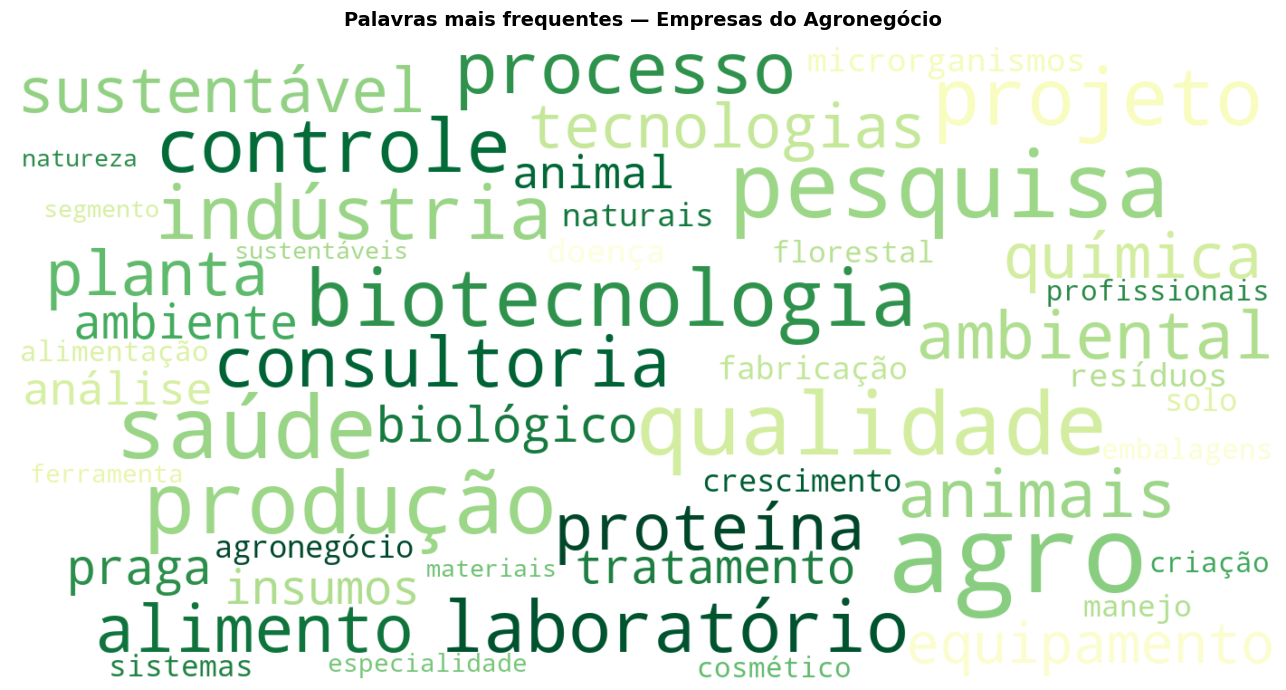

In [47]:
wc = WordCloud(
    width=1400, height=700,
    background_color='white',
    colormap='YlGn',       # verde do claro ao escuro
    stopwords=stopwords,
    max_words=50,
    collocations=False,
    prefer_horizontal=1.0,
    min_font_size=12,
    max_font_size=120,
).generate(texto)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('Palavras mais frequentes — Empresas do Agronegócio',
             fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

### Diagnóstico: Ribeirão Preto

In [48]:
df_rp = df[df['cidade'].str.contains('RIBEIR', na=False)].copy()

print(f"Total de empresas em Ribeirão Preto: {len(df_rp)}")
print(f"\nFormas como a cidade aparece na base:")
print(df_rp['cidade'].value_counts())
print(f"\nDistribuição por CNAE (divisão):")
print(df_rp['cnae_divisao'].value_counts().head(10))
print(f"\nEmpresas do agro em Ribeirão Preto:")
print(len(df_rp[df_rp.index.isin(df_agro.index)]))

Total de empresas em Ribeirão Preto: 0

Formas como a cidade aparece na base:
Series([], Name: count, dtype: int64)

Distribuição por CNAE (divisão):
Series([], Name: count, dtype: int64)

Empresas do agro em Ribeirão Preto:
0


Como o diagnóstico deu como nenhuma empresa está na cidade, fazemos uma correção

In [49]:
def corrigir_ribeirao(cidade):
    if pd.isna(cidade):
        return cidade
    cidade_norm = str(cidade).strip().upper().replace('\xa0', ' ')
    if 'RIBEIRAO PRETO' in cidade_norm or 'RIBEIRÃO PRETO' in cidade_norm:
        return 'RIBEIRÃO PRETO'
    return cidade.strip()

df['cidade'] = df['cidade'].apply(corrigir_ribeirao)

# Confirma
df_rp = df[df['cidade'] == 'RIBEIRÃO PRETO'].copy()
print(f"Total de empresas em Ribeirão Preto: {len(df_rp)}")
print(f"Empresas do agro em Ribeirão Preto: {len(df_rp[df_rp.index.isin(df_agro.index)])}")
print(f"\nTop CNAEs:")
print(df_rp['cnae_divisao'].value_counts().head(10))

Total de empresas em Ribeirão Preto: 267
Empresas do agro em Ribeirão Preto: 22

Top CNAEs:
cnae_divisao
86    46
85    32
62    31
72    28
47    20
82    12
74    10
70    10
71     8
73     7
Name: count, dtype: int64


In [50]:
# ── Mapa de nomes legíveis para os CNAEs de Ribeirão Preto ───────────────────
CNAE_NOMES = {
    '01': 'Agricultura e Pecuária',
    '02': 'Produção Florestal',
    '03': 'Pesca e Aquicultura',
    '10': 'Fabricação de Alimentos',
    '20': 'Defensivos e Fertilizantes',
    '28': 'Máquinas Agrícolas',
    '46': 'Comércio Atacadista',
    '47': 'Comércio Varejista',
    '62': 'Tecnologia da Informação',
    '70': 'Consultoria e Gestão',
    '71': 'Engenharia e P&D',
    '72': 'Pesquisa e Desenvolvimento',
    '73': 'Publicidade',
    '74': 'Design e Fotografia',
    '75': 'Atividades Veterinárias',
    '82': 'Serviços Administrativos',
    '85': 'Educação',
    '86': 'Saúde',
}

# Aplica na base toda
df['cnae_nome'] = df['cnae_divisao'].map(CNAE_NOMES).fillna('Outros')
df_rp['cnae_nome'] = df_rp['cnae_divisao'].map(CNAE_NOMES).fillna('Outros')

print("CNAEs de Ribeirão Preto com nomes:")
print(df_rp['cnae_nome'].value_counts().head(10))

CNAEs de Ribeirão Preto com nomes:
cnae_nome
Outros                        50
Saúde                         46
Educação                      32
Tecnologia da Informação      31
Pesquisa e Desenvolvimento    28
Comércio Varejista            20
Serviços Administrativos      12
Design e Fotografia           10
Consultoria e Gestão          10
Engenharia e P&D               8
Name: count, dtype: int64


In [51]:
# ── Prepara faturamento médio por setor em Ribeirão Preto ────────────────────
df_rp_fat = (df_rp.dropna(subset=['faturamento_num'])
                  .groupby('cnae_nome')['faturamento_num']
                  .agg(media='mean', count='count')
                  .query('count >= 3')
                  .reset_index()
                  .sort_values('media', ascending=True))

In [52]:
# ── Expansão do mapa de CNAEs ────────────────────────────────────────────────
CNAE_NOMES.update({
    '63': 'Serviços de TI e Informação',
    '69': 'Atividades Jurídicas',
    '32': 'Fabricação Diversa',
    '26': 'Eletrônicos e Informática',
    '58': 'Edição e Publicação',
    '56': 'Alimentação e Restaurantes',
    '21': 'Farmacêutica',
    '68': 'Imobiliário',
    '66': 'Seguros e Finanças',
    '27': 'Equipamentos Elétricos',
    '95': 'Reparação de Equipamentos',
    '81': 'Serviços de Limpeza',
    '79': 'Agências de Viagem',
    '64': 'Serviços Financeiros',
    '35': 'Energia',
    '33': 'Manutenção Industrial',
    '90': 'Artes e Cultura',
    '87': 'Assistência Social',
    '94': 'Organizações e Associações',
    '93': 'Esporte e Lazer',
    '43': 'Construção Civil',
    '96': 'Outros Serviços Pessoais',
    '59': 'Cinema e Audiovisual',
})

# Reaplica na base
df['cnae_nome']    = df['cnae_divisao'].map(CNAE_NOMES).fillna('Outros')
df_rp['cnae_nome'] = df_rp['cnae_divisao'].map(CNAE_NOMES).fillna('Outros')

print(f"Empresas ainda em 'Outros': {(df_rp['cnae_nome'] == 'Outros').sum()}")

Empresas ainda em 'Outros': 0


### Gráfico: Distribuição dos Setores em Ribeirão Preto

Ribeirão Preto concentra **267 empresas** na base — 8,3% do total — sendo o segundo 
maior polo do estado após São Paulo. As análises a seguir exploram o perfil setorial, 
o faturamento médio por setor e as empresas do agronegócio presentes na cidade.

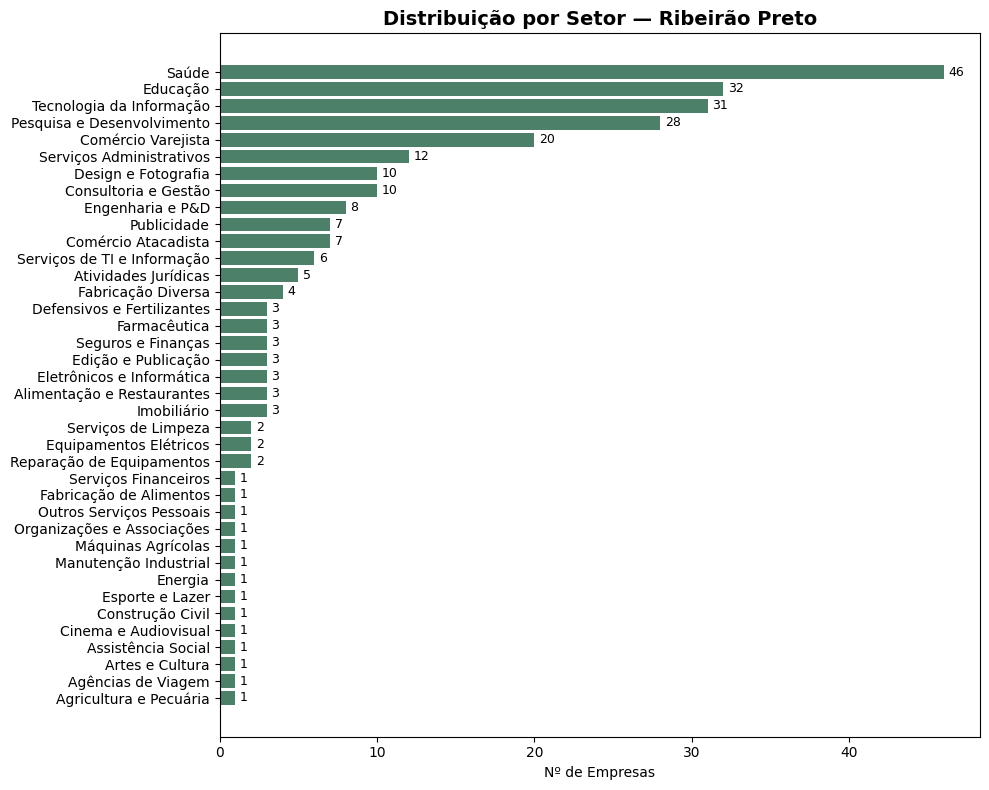

In [53]:
df_rp_cnae = (df_rp.groupby('cnae_nome')
                   .size()
                   .reset_index(name='quantidade')
                   .sort_values('quantidade', ascending=True))

fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(df_rp_cnae['cnae_nome'], df_rp_cnae['quantidade'],
               color='#2d6a4f', alpha=0.85)

# Adiciona valor no final de cada barra
for bar, val in zip(bars, df_rp_cnae['quantidade']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
            str(val), va='center', fontsize=9)

ax.set_title('Distribuição por Setor — Ribeirão Preto', fontsize=14, fontweight='bold')
ax.set_xlabel('Nº de Empresas')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### Faturamento médio por setor em Ribeirão Preto

Das 267 empresas de Ribeirão Preto, **22 pertencem ao recorte do agronegócio** — 
representando 8,2% do total local. O gráfico mostra a distribuição dessas empresas 
por subsetor, e a listagem completa com nome, setor e faturamento é exibida logo abaixo.

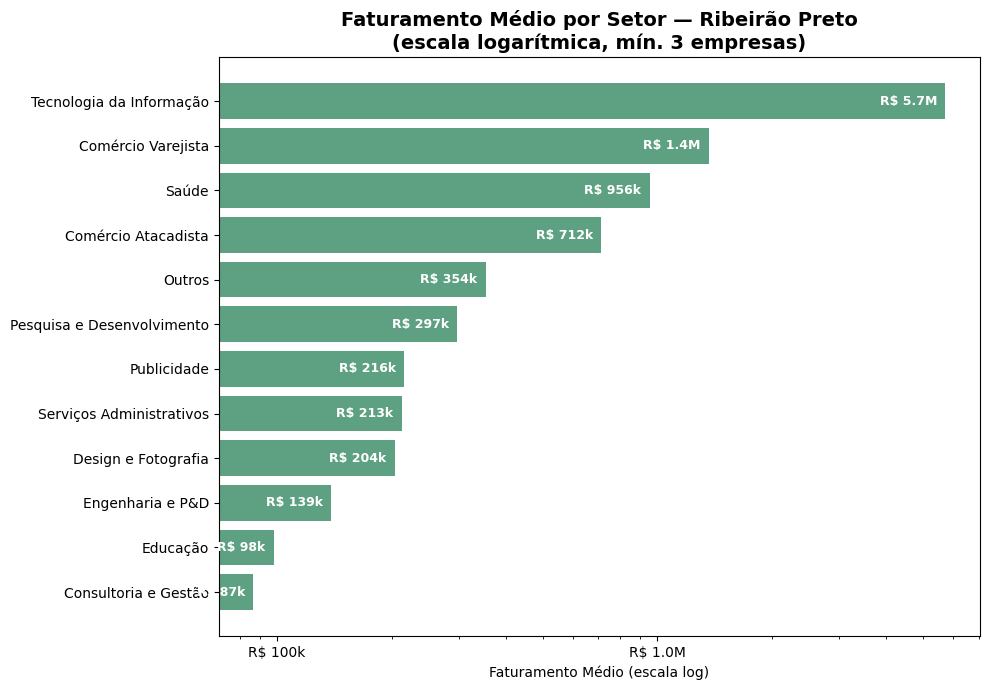

In [54]:
fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.barh(df_rp_fat['cnae_nome'], df_rp_fat['media'],
               color='#40916c', alpha=0.85)

# Labels dentro da barra (alinhado à direita)
for bar, val in zip(bars, df_rp_fat['media']):
    label = f'R$ {val/1e3:.0f}k' if val < 1e6 else f'R$ {val/1e6:.1f}M'
    ax.text(bar.get_width() * 0.95, bar.get_y() + bar.get_height() / 2,
            label, va='center', ha='right', fontsize=9, color='white', fontweight='bold')

ax.set_xscale('log')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'R$ {x/1e3:.0f}k' if x < 1e6 else f'R$ {x/1e6:.1f}M'
))

ax.set_title('Faturamento Médio por Setor — Ribeirão Preto\n(escala logarítmica, mín. 3 empresas)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Faturamento Médio (escala log)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### Empresas do Agronegócio em Ribeirão Preto

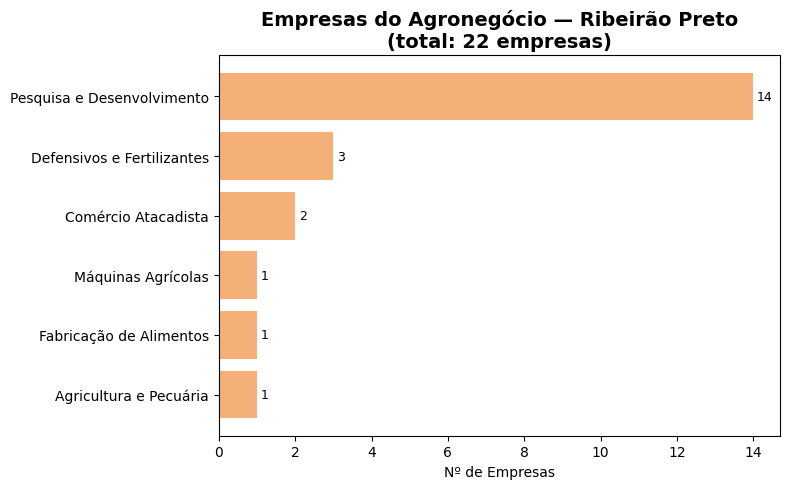

In [55]:
df_rp_agro = df_rp[df_rp.index.isin(df_agro.index)].copy()

df_rp_agro_cnae = (df_rp_agro.groupby('cnae_nome')
                              .size()
                              .reset_index(name='quantidade')
                              .sort_values('quantidade', ascending=True))

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.barh(df_rp_agro_cnae['cnae_nome'], df_rp_agro_cnae['quantidade'],
               color='#f4a261', alpha=0.85)

for bar, val in zip(bars, df_rp_agro_cnae['quantidade']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
            str(val), va='center', fontsize=9)

ax.set_title(f'Empresas do Agronegócio — Ribeirão Preto\n(total: {len(df_rp_agro)} empresas)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Nº de Empresas')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

Quais as empresas que estão nesse gráfico: 

In [56]:

print(f"Empresas do agronegócio em Ribeirão Preto ({len(df_rp_agro)}):\n")
print(df_rp_agro[['nome', 'cnae_nome', 'faturamento_num']]
      .sort_values('cnae_nome')
      .assign(faturamento=lambda x: x['faturamento_num']
              .apply(lambda v: f'R$ {v:,.0f}'.replace(',', '.') if pd.notna(v) else 'Não informado'))
      .drop(columns='faturamento_num')
      .to_string(index=False))

Empresas do agronegócio em Ribeirão Preto (22):

                             nome                  cnae_nome   faturamento
                        Sardrones     Agricultura e Pecuária    R$ 360.000
                     Bembras Agro        Comércio Atacadista Não informado
                          Radtech        Comércio Atacadista     R$ 60.000
             YOSEN Nanotechnology Defensivos e Fertilizantes    R$ 521.904
                        JV Biotec Defensivos e Fertilizantes     R$ 60.000
 TZ Biotec (antiga TZ Epigentech) Defensivos e Fertilizantes Não informado
                           Avesso    Fabricação de Alimentos     R$ 50.000
Nock - Engenharia e Biotecnologia         Máquinas Agrícolas Não informado
                        Narcissus Pesquisa e Desenvolvimento     R$ 60.000
                            Vetra Pesquisa e Desenvolvimento     R$ 60.000
                      Lychnoflora Pesquisa e Desenvolvimento    R$ 360.000
            EditBio Biotecnologia Pesquisa e Desenv

### Diagnóstico: empresas de P&D (CNAE 72)

In [57]:
df_pd = df[df['cnae_divisao'] == '72'].copy()

print(f"Total de empresas de P&D: {len(df_pd)}")
print(f"Ribeirão Preto: {len(df_pd[df_pd['cidade'] == 'RIBEIRÃO PRETO'])}")
print(f"Sem ano de fundação: {df_pd['ano_fundacao'].isna().sum()}")
print(f"\nTop 10 cidades:")
print(df_pd['cidade'].value_counts().head(10))
print(f"\nFaturamento:")
print(df_pd['faturamento_num'].describe().apply(lambda x: f'R$ {x:,.0f}'))

Total de empresas de P&D: 157
Ribeirão Preto: 28
Sem ano de fundação: 0

Top 10 cidades:
cidade
São Paulo              64
RIBEIRÃO PRETO         28
Piracicaba             11
São Carlos              9
São Paulo               7
Santana de Parnaíba     3
Araraquara              3
São Carlos              3
Campinas                2
Paulínia                2
Name: count, dtype: int64

Faturamento:
count             R$ 96
mean       R$ 8,126,615
std       R$ 58,050,589
min              R$ 600
25%           R$ 60,000
50%           R$ 60,000
75%          R$ 273,875
max      R$ 558,353,039
Name: faturamento_num, dtype: str


In [58]:
# ── Corrige diretamente no df principal ─────────────────────────────────────
df['cidade'] = df['cidade'].apply(lambda x:
    str(x).strip().replace('\xa0', ' ') if pd.notna(x) else x
)

CORRECOES_CIDADES = {
    'SAO PAULO':      'SÃO PAULO',
    'SAO CARLOS':     'SÃO CARLOS',
    'RIBEIRAO PRETO': 'RIBEIRÃO PRETO',
}

df['cidade'] = df['cidade'].apply(lambda x:
    CORRECOES_CIDADES.get(str(x).strip().upper(), x) if pd.notna(x) else x
)

# ── Recria df_pd e df_rp do zero ────────────────────────────────────────────
df_pd = df[df['cnae_divisao'] == '72'].copy()
df_rp = df[df['cidade'] == 'RIBEIRÃO PRETO'].copy()

print("Top 10 cidades após correção:")
print(df_pd['cidade'].value_counts().head(10))

Top 10 cidades após correção:
cidade
São Paulo              71
RIBEIRÃO PRETO         28
São Carlos             12
Piracicaba             11
Santana de Parnaíba     3
Araraquara              3
Campinas                2
Paulínia                2
São José dos Campos     2
Santa Rosa              1
Name: count, dtype: int64


## Recorte: Empresas de Pesquisa e Desenvolvimento (CNAE 72)

Esta seção analisa as 157 empresas classificadas no CNAE 72 (Pesquisa e Desenvolvimento 
Científico), com foco em três perspectivas: evolução temporal, concentração geográfica 
e vocabulário de inovação. Esse grupo é especialmente relevante para o ecossistema de 
inovação, patentes e propriedade intelectual.

### Crescimento de Empresas de P&D por Ano de Fundação

Crescimento consistente desde 2002, com pico em 2021 — período em que a pandemia 
acelerou investimentos em biotecnologia, saúde e agtech. A queda aparente em 2024-2025 
é esperada, pois empresas recém-fundadas ainda não necessariamente ingressaram no programa.

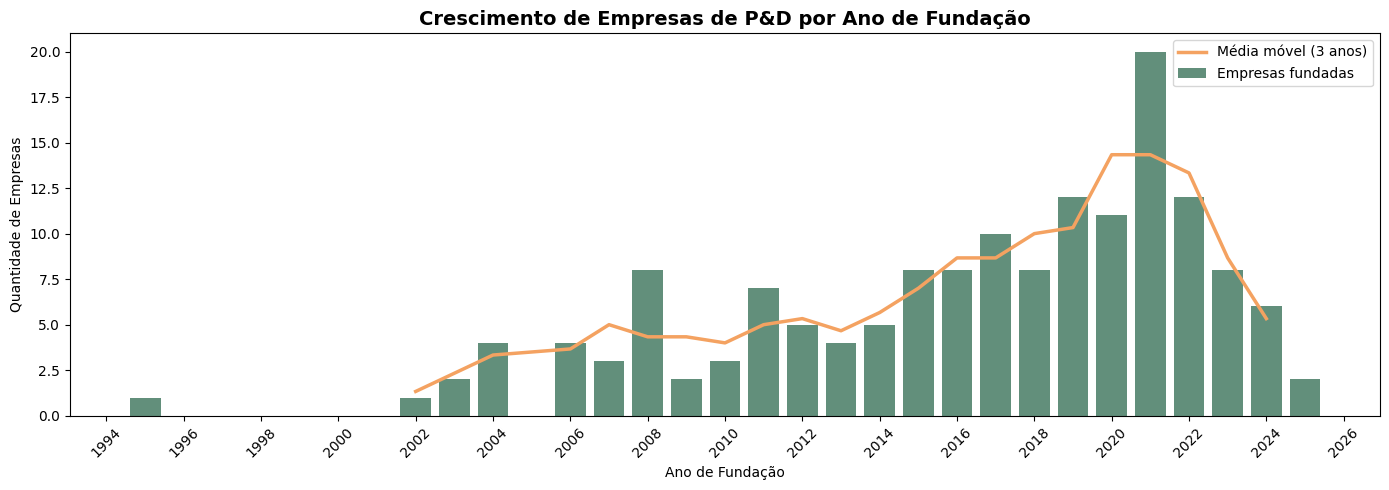

In [59]:
df_pd_ano = (df_pd[df_pd['ano_fundacao'] >= 1990]
               .groupby('ano_fundacao')
               .size()
               .reset_index(name='quantidade'))

df_pd_ano['media_movel'] = df_pd_ano['quantidade'].rolling(window=3, center=True).mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(df_pd_ano['ano_fundacao'], df_pd_ano['quantidade'],
       color='#2d6a4f', alpha=0.75, width=0.8, label='Empresas fundadas')
ax.plot(df_pd_ano['ano_fundacao'], df_pd_ano['media_movel'],
        color='#f4a261', linewidth=2.5, label='Média móvel (3 anos)')
ax.set_title('Crescimento de Empresas de P&D por Ano de Fundação',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Ano de Fundação')
ax.set_ylabel('Quantidade de Empresas')
ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Concentração de Empresas de P&D por Cidade

Ribeirão Preto aparece como **segundo maior polo de P&D do estado**, com 28 empresas —
mais que o dobro de São Carlos (12) e Piracicaba (11), tradicionais cidades universitárias 
do interior paulista. Esse dado reforça o peso do ecossistema de inovação da cidade.

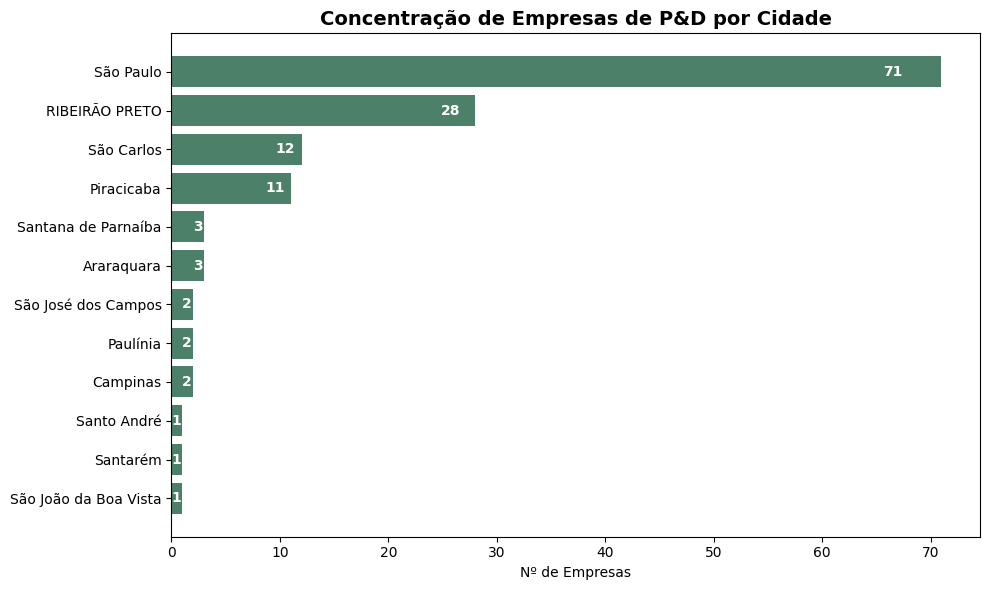

In [60]:
df_pd_cidade = (df_pd.groupby('cidade')
                     .size()
                     .reset_index(name='quantidade')
                     .sort_values('quantidade', ascending=True)
                     .tail(12))  # top 12 cidades

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_pd_cidade['cidade'], df_pd_cidade['quantidade'],
               color='#2d6a4f', alpha=0.85)

for bar, val in zip(bars, df_pd_cidade['quantidade']):
    ax.text(bar.get_width() * 0.95, bar.get_y() + bar.get_height() / 2,
            str(val), va='center', ha='right', fontsize=10,
            color='white', fontweight='bold')

ax.set_title('Concentração de Empresas de P&D por Cidade',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Nº de Empresas')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### Nuvem de palavras de Inovação - Empresas P&D

Gerado a partir das descrições das 157 empresas de P&D, após remoção de stopwords.
O vocabulário evidencia dois eixos temáticos principais: **ciências da vida** 
(biotecnologia, diagnóstico, saúde, proteína, microrganismos) e **agronegócio** 
(agrícola, agricultura, insumos, sustentável), confirmando a intersecção entre 
inovação e agro que caracteriza o ecossistema mapeado.

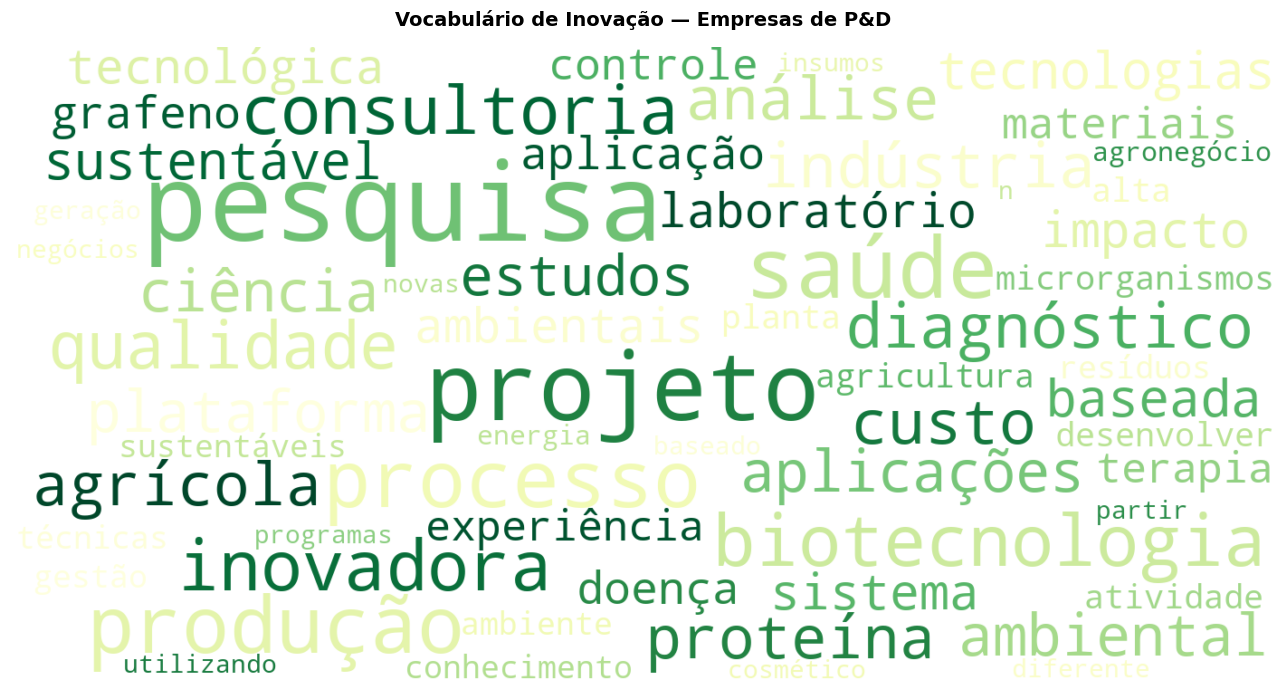

In [61]:
stopwords_pd = set(STOPWORDS)
stopwords_pd.update([
    'ao', 'aos', 'da', 'das', 'de', 'do', 'dos', 'na', 'nas', 'no', 'nos',
    'um', 'uma', 'uns', 'umas', 'se', 'em', 'é', 'ou', 'à', 'às', 'a',
    'pela', 'pelo', 'por', 'para', 'com', 'que', 'como', 'entre', 'além',
    'através', 'ainda', 'sendo', 'também', 'foi', 'tem', 'são', 'atua',
    'atuamos', 'oferece', 'oferecemos', 'desenvolve', 'desenvolvemos',
    'busca', 'somos', 'pode', 'podem', 'empresa', 'empresas', 'serviço',
    'serviços', 'área', 'áreas', 'solução', 'soluções', 'mercado',
    'desenvolvimento', 'produtos', 'produto', 'base', 'anos', 'brasil',
    'brasileira', 'missão', 'necessidade', 'objetivo', 'forma', 'grande',
    'resultado', 'resultados', 'novo', 'nova', 'sempre', 'desde', 'foco',
    'fundada', 'fundado', 'outro', 'outros', 'outra', 'outras', 'onde',
    'o', 'os', 'mais', 'sua', 'suas', 'seu', 'seus', 'nosso', 'nossa',
    'nossos', 'nossas', 'não', 'há', 'todo', 'toda', 'todos', 'todas',
    'cada', 'esta', 'este', 'esse', 'essa', 'isso', 'ser', 'estar',
    'visando', 'até', 'bem', 'ano', 'assim', 'conta', 'pessoas', 'vida',
    'maior', 'alto', 'd', 'e', 'startup', 'startups', 'cliente', 'clientes',
    'inovação', 'tecnologia', 'paulo', 'são', 'usp', 
    'dado', 'dados', 'meio', 'equipe', 'voltada', 'voltado',
    'focada', 'focado', 'especializada', 'especializado',
    'está', 'sobre', 'uso', 'técnica', 'alto', 'nacional',
    'humana', 'social', 'trabalho', 'parceria', 'setor',
    'negócio', 'programa', 'profissionais',
])

texto_pd = ' '.join(df_pd['descricao'].dropna().tolist()).lower()

wc = WordCloud(
    width=1400, height=700,
    background_color='white',
    colormap='YlGn',
    stopwords=stopwords_pd,
    max_words=60,
    collocations=False,
    prefer_horizontal=1.0,
    min_font_size=12,
    max_font_size=120,
).generate(texto_pd)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('Vocabulário de Inovação — Empresas de P&D',
             fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

## Gráfico AgTech x Agro Tradicional

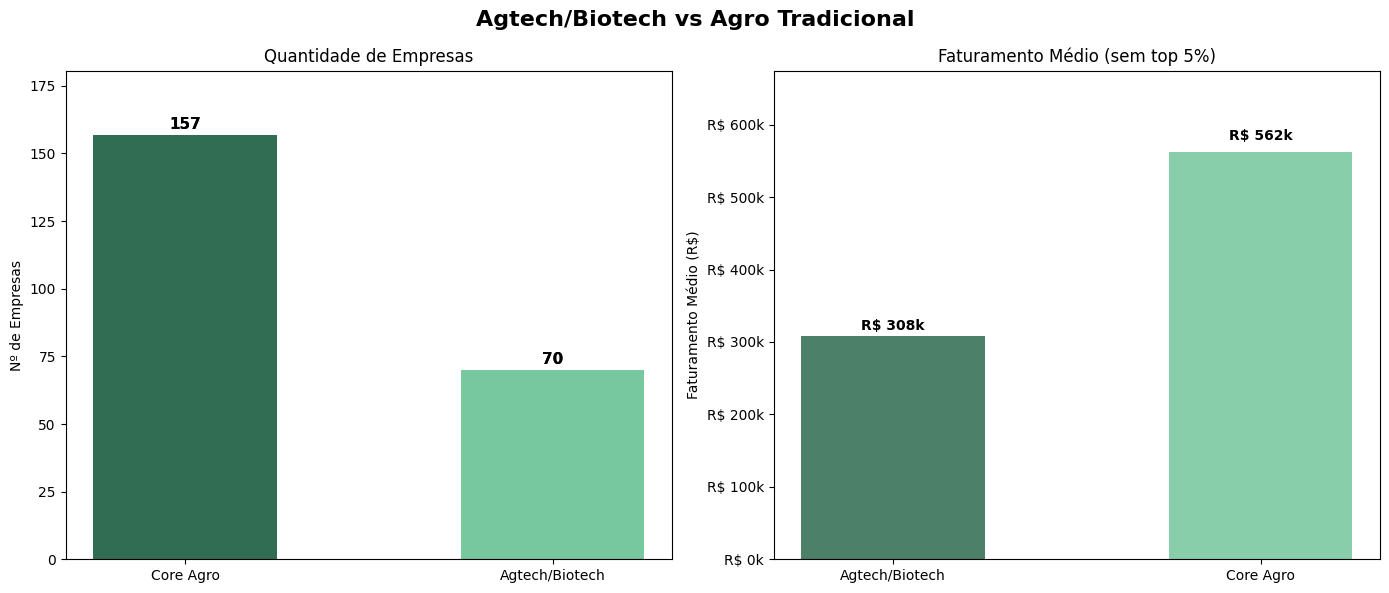

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Agtech/Biotech vs Agro Tradicional', fontsize=16, fontweight='bold')

# Painel 1 — quantidade de empresas
contagem = df_agro['origem'].value_counts().reset_index()
contagem.columns = ['origem', 'quantidade']

axes[0].bar(contagem['origem'], contagem['quantidade'],
            color=['#2d6a4f', '#74c69d'], alpha=0.85, width=0.5)
for i, (_, row) in enumerate(contagem.iterrows()):
    axes[0].text(i, row['quantidade'] + 2, str(row['quantidade']),
                 ha='center', fontsize=11, fontweight='bold')
axes[0].set_title('Quantidade de Empresas')
axes[0].set_ylabel('Nº de Empresas')
axes[0].set_ylim(0, contagem['quantidade'].max() * 1.15)

# Painel 2 - faturamento médio sem outliers (abaixo do p95)
contagem = df_agro['origem'].value_counts().reset_index()
contagem.columns = ['origem', 'quantidade']

axes[0].bar(contagem['origem'], contagem['quantidade'],
            color=['#2d6a4f', '#74c69d'], alpha=0.85, width=0.5)
for i, (_, row) in enumerate(contagem.iterrows()):
    axes[0].text(i, row['quantidade'] + 2, str(row['quantidade']),
                 ha='center', fontsize=11, fontweight='bold')
axes[0].set_title('Quantidade de Empresas')
axes[0].set_ylabel('Nº de Empresas')
axes[0].set_ylim(0, contagem['quantidade'].max() * 1.15)

# Painel 2 — faturamento médio sem outliers (abaixo do p95)
p95_agro = df_agro['faturamento_num'].quantile(0.95)
df_agro_fat = (df_agro[df_agro['faturamento_num'] <= p95_agro]
               .dropna(subset=['faturamento_num'])
               .groupby('origem')['faturamento_num']
               .mean()
               .reset_index())

axes[1].bar(df_agro_fat['origem'], df_agro_fat['faturamento_num'],
            color=['#2d6a4f', '#74c69d'], alpha=0.85, width=0.5)
for i, (_, row) in enumerate(df_agro_fat.iterrows()):
    label = f"R$ {row['faturamento_num']/1e3:.0f}k"
    axes[1].text(i, row['faturamento_num'] * 1.03, label,
                 ha='center', fontsize=10, fontweight='bold')
axes[1].set_title('Faturamento Médio (sem top 5%)')
axes[1].set_ylabel('Faturamento Médio (R$)')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x/1e3:.0f}k'))
axes[1].set_ylim(0, df_agro_fat['faturamento_num'].max() * 1.2)

plt.tight_layout()
plt.show()